In [89]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import argrelextrema

def invert_image(image):
    return 255 - image

# Toy example for the classical Kalman Filter

## Continuous time signals $s_1(t) = cos(t)$ and $s_2(t) = cos(2t)$

## Sampling $s(t)$ 

sampling time step dt      = 0.1 s
sampling frequency step df = 10.0 Hz
N = 200 samples


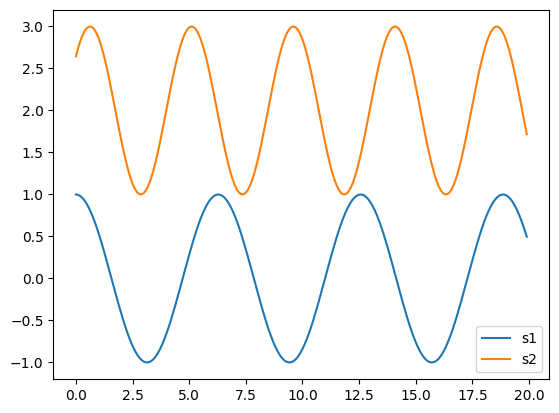

In [90]:
dt = 0.1   # Time step
N = 200    # Number of samples

print('sampling time step dt      =', dt, 's')
print('sampling frequency step df =', 1/dt, 'Hz')
print('N =', N, 'samples')

t = np.arange(0, N * dt, dt)  # Generates n points
s1 = np.cos(t)
s2 = np.sin(1.4*t + 0.7)
signals = np.array([s1, s2])

plt.plot(t, s1, label='s1') 
plt.plot(t, s2+2, label='s2')
plt.legend()
plt.show()

## Drawing signal $s$ in a pixel grid to create a raster image

In [91]:
### Parameters

# size of the pixels grid
height = 100
width = 200

# margins
t_margin = 0
l_margin = 0
r_margin = 0
b_margin = 0

line_thickness = 1 # pixels

overlap_percentages = [0, 0.1, 0.2, 0.3]
###

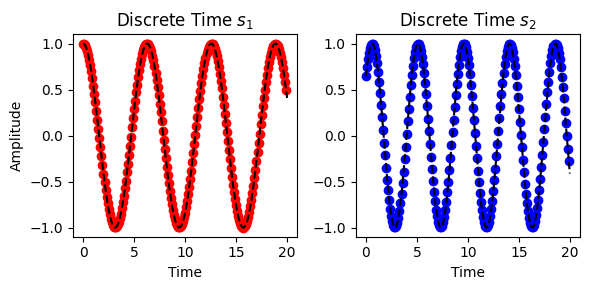

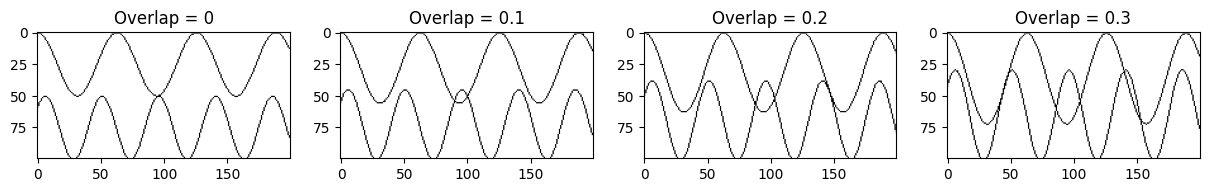

In [101]:
images = []
for overlap_percentage in overlap_percentages:
    background = np.full((height, width), 255, dtype=np.int32)  # background of binary image

    num_signals = len(signals)
            
    available_height = height - t_margin - b_margin  # Space available for signals
    max_amplitude = (available_height / num_signals) / (1 - overlap_percentage)  # Control overlap
            
    # Create vertical offsets while considering margins and overlap
    vertical_offsets = np.linspace(t_margin + max_amplitude / 2, height - b_margin - max_amplitude / 2, num_signals)
            
    # Horizontal shifting
    available_width = width - l_margin - r_margin
    horizontal_offsets = l_margin
    for i, signal in enumerate(signals):
        # Center, normalize and scale signal
        signal = (signal - np.mean(signal)) / np.max(np.abs(signal))  # Center and normalize
        scaled_signal = (max_amplitude / 2) * signal + vertical_offsets[len(signals)-1-i]  # Rescale amplitude to fit within frame
        scaled_signal = available_height - scaled_signal
                
        # Create x-coordinates for plotting with horizontal offset
        x_coords = np.linspace(0, available_width - 1, len(signal)).astype(np.int32) + horizontal_offsets
        y_coords = scaled_signal.astype(np.int32)  # Ensure y-coordinates stay in bounds
                
        # plt.scatter(x_coords, y_coords, color='r')
        # plt.show()

        # Draw 
        for j in range(1, len(x_coords)):
            cv2.line(background, (x_coords[j-1], y_coords[j-1]), (x_coords[j], y_coords[j]), 0, line_thickness)

    images.append(background)

images = np.array(images)

# Display the images
fig1, ax1 = plt.subplots(1, 2, figsize=(6, 3))

ax1[0].scatter(t, s1, color='r')
ax1[0].set_title('Discrete Time $s_1$')
ax1[0].set_xlabel('Time')
ax1[0].set_ylabel('Amplitude')
ax1[0].plot(np.linspace(0, N*dt, 1000), np.cos(np.linspace(0, N*dt, 1000)), linestyle='--', color='k')

ax1[1].scatter(t, s2, color='b')
ax1[1].set_title('Discrete Time $s_2$')
ax1[1].set_xlabel('Time')
# ax1[1].set_ylabel('Amplitude')
ax1[1].plot(np.linspace(0, N*dt, 1000), np.sin(1.4*np.linspace(0, N*dt, 1000)+0.7), linestyle='--', color='k')

fig1.tight_layout()

fig2, ax2 = plt.subplots(1, len(images), figsize=(15, 8))
for i, image in enumerate(images):
    ax2[i].set_title('Overlap = ' + str(overlap_percentages[i]))
    ax2[i].imshow(image, cmap='gray', vmin=0, vmax=255)
    
# Show the plot
plt.show()

In [93]:
inverted_images = np.array([invert_image(image) for image in images]) / np.max(images)
starting = np.array([[48, 89], [54, 88], [61, 87], [69, 85]])

for inverted_image in inverted_images:
    print(np.where(inverted_image[:, 0] > 1e-16))
    # # find the len(signals) local maxima of inverted_image[:, 0] using argrelextrema
    # min_indices = argrelextrema(inverted_image[:, 0], np.less, order=1)[0]
    # print(min_indices)
    # # sorted_minima = min_indices[np.argsort(inverted_image[min_indices])]

(array([ 9, 10, 51], dtype=int64),)
(array([10, 11, 45], dtype=int64),)
(array([11, 12, 13, 38], dtype=int64),)
(array([13, 14, 30], dtype=int64),)


## Implement the KF on the raster image

### State Transition Model

The state at time $k$ is defined as the 4D vector 
$$
\mathbf{x}_k = \begin{bmatrix} px \\ p_y \\ v_x \\ v_y \end{bmatrix}
$$
where:
- $p_x$ and $p_y$ are the positions in the x and y directions, respectively.
- $v_x$ and $v_y$ are the velocities in the x and y directions, respectively.

Note that the x and y directions correspond to the horizontal and vertical axes of the raster image respectively.

The state transition model for a constant velocity motion in 2D is given by:
$$
\mathbf{x}_{k+1} = \mathbf{A} \mathbf{x}_k + \mathbf{w}_k
$$
Where:
- $\mathbf{x}_{k+1}$ is the state at time $k+1$.
- $\mathbf{x}_k$ is the state at time $k$.
- $\mathbf{A}$ is the state transition matrix.
- $\mathbf{w}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{Q})$ is the process noise at time $k$.

The measurement model is:
$$
\mathbf{z}_k = \mathbf{H} \mathbf{x}_k + \mathbf{v}_k
$$
Where:
- $\mathbf{z}_k$ is the measurement at time $k$.
- $\mathbf{H}$ is the measurement matrix.
- $\mathbf{v}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{R})$ is the measurement noise at time $k$.

Both $\mathbf{w}_k$ and $\mathbf{v}_k$ are white noise processes.

### Prediction and Update for Kalman Filter

1. **Prediction Step:**

The prediction step involves predicting the state at time $k+1$ using the state at time $k$ and the state transition model.

- **Predicted state estimate:**
$$
\hat{\mathbf{x}}_{k+1|k} = \mathbf{A} \hat{\mathbf{x}}_{k|k}
$$

- **Predicted covariance estimate:**
$$
\mathbf{P}_{k+1|k} = \mathbf{A} \mathbf{P}_{k|k} \mathbf{A}^T + \mathbf{Q}
$$
Where:
- $\hat{\mathbf{x}}_{k+1|k}$ is the predicted state estimate.
- $\mathbf{P}_{k+1|k}$ is the predicted covariance estimate.
- $\mathbf{P}_{k|k}$ is the current state covariance estimate.

2. **Update Step:**

Once a new measurement $\mathbf{z}_k$ is available, the update step corrects the predicted state and covariance.

- **Kalman Gain:**
$$
\mathbf{K}_k = \mathbf{P}_{k|k-1} \mathbf{H}^T \left( \mathbf{H} \mathbf{P}_{k|k-1} \mathbf{H}^T + \mathbf{R} \right)^{-1}
$$
Where:
- $\mathbf{K}_k$ is the Kalman gain.

- **Updated state estimate:**
$$
\hat{\mathbf{x}}_{k|k} = \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_k \left( \mathbf{z}_k - \mathbf{H} \hat{\mathbf{x}}_{k|k-1} \right)
$$

- **Updated covariance estimate:**
$$
\mathbf{P}_{k|k} = \left( \mathbf{I} - \mathbf{K}_k \mathbf{H} \right) \mathbf{P}_{k|k-1}
$$

Where:
- $\hat{\mathbf{x}}_{k|k}$ is the updated state estimate.
- $\mathbf{P}_{k|k}$ is the updated covariance estimate.
- $\mathbf{I}$ is the identity matrix.

#### Choice of $\Delta t$

Assuming no corruption of the time axis of the raster image (the horizontal axis), the formula is:
$$ \Delta t = \frac{\text{available\_width}}{N_{\text{samples}} - 1} $$

In our case, $$\Delta t = 1 \quad \text{pixels}$$.

In [94]:
# Define the system dynamics

### Parameters
Dt = 1 # Time step related to the state transition matrix A, ! different than sampling rate dt of signal s

# Assuming no process noise
sigma_p_x = 0
sigma_p_y = 0
sigma_v_x = 0
sigma_v_y = 0

# Assuming no measurement noise
sigma_m_x = 0
sigma_m_y = 0
###

A = np.array([[1, 0, Dt, 0],
              [0, 1, 0, Dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

Q = np.array([[sigma_p_x**2, 0, 0, 0],
              [0, sigma_p_y**2, 0, 0],
              [0, 0, sigma_v_x**2, 0],
              [0, 0, 0, sigma_v_y**2]])

R = np.array([[sigma_m_x**2, 0],
              [0, sigma_m_y**2]])

In [95]:
# Define Prediction and Update steps for KF
def predict(x, P, A, Q):
    x = A @ x
    P = A @ P @ A.T + Q
    return x, P

def update(x, P, z, H, R):
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    x = x + K @ (z - H @ x)
    P = P - K @ H @ P
    return x, P